# Topic Modeling

The goal of this notebook is two-fold:
* identify the main topics of the corpus through LDA and clustering (unsupervised approach)
* train a text classifier based on these topics (supervised learning).

### Contents

__Preliminaries__
* a. Overview of text modeling techniques
* b. Imports

__1. LDA__

__2. Clustering__
* a. Tf-Idf for Clustering
* b. K-Means
* c. DBSCAN

__3. Topic classifier__

What's next

# Preliminaries

__a. Overview of text modeling techniques__

* [LDA](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

* Clustering. In order to build clusters we have to transform our news articles into a numerical representation that models can handle. Here we go for old good tf-idf vectors (we will test more state-of-the-art techniques in the next steps). Algorithms: K-Means and DBSCAN seem like the most relevant options to begin with.

* ?

__b. Imports__

If you don't have already done so, please download these NLTK dependancies by running the following lines:

> nltk.download('wordnet')

> nltk.download('stopwords')

In [1]:
# Classic packages

import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import random 
random.seed(a=2905) # set random seed 
import pickle


# NLP packages

import gensim
from gensim import corpora

import spacy
try: 
    print("fr_core_news_sm loaded")
    nlp = spacy.load("fr_core_news_sm") # load pre-trained models for French
except:
    print("fr loaded")
    nlp=spacy.load('fr') # fr calls fr_core_news_sm 

import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer # not adapted to French?
from nltk.stem.snowball import FrenchStemmer # already something 
# --> Lemmatizer would be better --> use spaCy lemmatizer

# ML with sklearn
import sklearn.cluster
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer 
from sklearn.feature_extraction.text import  TfidfVectorizer


fr_core_news_sm loaded


In [2]:
# data
news_df=pd.read_csv("./articles.csv")

# 1. Latent Dirichlet Allocation (LDA)


Main idea: Each document is represented as a distribution over topics, and each topic is represented as a distribution over words.
Here we do not set the number of topics in advance, we rather set it arbitrarily like a threshold and see if the results are relevant.

Code freely adapted from this [TDS post](https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21).



__Text cleaning for LDA__

* tokenize words (here using spacy parser for French)
* lemmatize (using NLTK WordNetLemmatizer)
* stopwords removal (using the default NLTK stopwords list for French)
* apply pipeline on titles and text bodies

In [3]:
## spacy LDA

spacy.load('fr')
from spacy.lang.fr import French
parser = French()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

# test
# we see it's basically a conversion of the words from the split sentence into lower case
# but actually there is more under the hood because of the use of a parser
tokenize("Il était une fois dans l'Ouest, une troupe de cowboys intrépides.")

['il',
 'était',
 'une',
 'fois',
 'dans',
 "l'",
 'ouest',
 ',',
 'une',
 'troupe',
 'de',
 'cowboys',
 'intrépides',
 '.']

In [4]:
# stopwords removal

#v0 : basic list
fr_stop = set(nltk.corpus.stopwords.words('french'))
#v1 : numbers
my_fr_stop=fr_stop.union({'un' ,'deux','trois','quatre','cinq','six','sept','huit','neuf','dix',
                          'onze', 'douze', 'treize','quatorze', 'quinze', 'seize', 
                          'vingt', 'trente', 'quarante', 'cinquante','soixante','cent'}, fr_stop)
#v2 : conj + det + verbs
my_fr_stop=fr_stop.union({'ce', 'celui', 'cette', 'cet', 'celui-là', 'celui-ci', 
                          'le', 'la', 'les', 'de', 'des', 'du',
                          'mais', 'où', 'et', 'donc', 'or', 'ni', 'car', 'depuis', 'quand', 'que', 'qui', 'quoi',
                          'ainsi', 'alors', 'avant', 'après', 'comme', 
                          'être', 'avoir', 'faire', 
                          'autre'})

#'mille'  'million' 'milliard' 'billion' are not added to the stopwords list because they are more discriminative

print(my_fr_stop)

{'serions', 'ta', 'vos', 'il', 'seront', 'd', 'étions', 'as', 'seriez', 'eues', 'vous', 'sa', 'c', 'fus', 'eurent', 'toi', 'fusse', 'étante', 'eus', 'suis', 'la', 'serai', 'qu', 'furent', 'étantes', 'avait', 'fûmes', 'fussions', 'aurai', 'eût', 'étées', 'lui', 'ait', 'pas', 'faire', 'leur', 'tu', 'ainsi', 'eux', 'avais', 'auras', 'ses', 'l', 'ni', 'se', 'ayante', 'été', 'eu', 'à', 'aurez', 'quoi', 'soyez', 'que', 'ont', 'aies', 'aviez', 'soient', 'fussent', 'aux', 'eusse', 'quand', 'sur', 'avant', 'sommes', 'aurait', 'car', 'serait', 'soit', 'ils', 'serons', 'j', 'dans', 'avaient', 'avions', 'y', 'qui', 'sont', 'avons', 'ce', 'fût', 'aura', 'les', 'en', 'on', 'le', 'serais', 'eussions', 'après', 'eue', 'aurais', 'm', 'avez', 'ayant', 'soyons', 'et', 'ma', 'étée', 'ayantes', 'étais', 'celui', 'moi', 'eussiez', 'eut', 'fussiez', 'ayants', 'eûmes', 'mon', 'fusses', 'depuis', 'celui-là', 'auraient', 'par', 'mes', 'eusses', 'aurions', 'aie', 'ayez', 'du', 'une', 'n', 'tes', 't', 'cet', 'alo

In [5]:
# Comparison: nltk french stemmer vs spacy french lemmatizer

# spacy
print("\nLemmas")
doc = nlp(u"les manifestations qui ont agitées la France ces derniers mois")
for token in doc:
    print(token, '-->', token.lemma_)
print("\nStems")
stemmer = FrenchStemmer()
for w in "les manifestations qui ont agitées la France ces derniers mois".split():
    print(w, '-->', stemmer.stem(w))


Lemmas
les --> le
manifestations --> manifestation
qui --> qui
ont --> avoir
agitées --> agiter
la --> le
France --> France
ces --> ce
derniers --> dernier
mois --> mois

Stems
les --> le
manifestations --> manifest
qui --> qui
ont --> ont
agitées --> agit
la --> la
France --> franc
ces --> ce
derniers --> derni
mois --> mois


We prefer to use the lemmas over the stems because they tend to be more informative and closer to the actual root word.

In [6]:
import re
words = ['python 3', 'python3', '1something', '2', '434', 'python 35', '1 ', ' 232']
for word in words:
    print("'{}' => '{}'".format(word, re.sub(r'\b\d+\b', '', word)))


'python 3' => 'python '
'python3' => 'python3'
'1something' => '1something'
'2' => ''
'434' => ''
'python 35' => 'python '
'1 ' => ' '
' 232' => ' '


In [7]:
# Preprocessing  routine

def prepare_text(text):
    """
    Input:
    ------
    text: string, raw text
    
    Output:
    ------
    tokens: list of string, tokenized, filtered and lemmatized words from the input text
    """
    tokens = tokenize(text) # split and lower case
    tokens=[re.sub(r'\b\d+\b', '', token) for token in tokens] # get rid of digits
    tokens = [token for token in tokens if len(token) > 4] # arbitrary length, +get rid of empty strings
    tokens = [token for token in tokens if token not in my_fr_stop] # stopwords
    doc = nlp(' '.join(tokens)) # pave the wave for spacy lemmatizer
    tokens = [token.lemma_ for token in doc] # obtain lemmas
    return tokens  

In [8]:
title_tokens = []
text_tokens = []

## Apply on titles ##

for t in news_df.title:
    tokens = prepare_text(t)
    title_tokens.append(tokens)
        
## Apply on titles ##

for t in news_df.text:
    tokens = prepare_text(t)
    text_tokens.append(tokens)

print(news_df.title[:1])        
print(title_tokens[:1])
print(news_df.text[:1][:20])  
print(text_tokens[0][:10])

0    Tintin dans l'espace
Name: title, dtype: object
[['tintin', 'espac']]
0    Trois semaines à bord de la station soviétique...
Name: text, dtype: object
['trois', 'semaine', 'station', 'soviétique', 'jean-loup', 'chrétien', 'premier', 'ouest-européen', 'sortir', 'espace']


In [9]:
## ?? espac / espace 
doc = nlp(u"Tintin dans l'espace a quitté la France, il n'aura plus besoin de francs.")
for token in doc:
    print(token, '-->', token.lemma_)

Tintin --> tintin
dans --> dans
l' --> le
espace --> espace
a --> avoir
quitté --> quitter
la --> le
France --> France
, --> ,
il --> il
n' --> n'
aura --> avoir
plus --> plus
besoin --> besoin
de --> de
francs --> franc
. --> .


__Visualize results with a wordcloud__

We can control the quality of our preprocessing by plotting a wordcloud.

We are satisfied by the quality of the processed titles since most of the words we see are nouns eligible as key words to describe an article.
There is still room for improvement  on the side of article bodies (we spot a few link words, noun articles and adverbs we could get rid of through the stopwords list).

//*Eventuellement on enrichira la liste de stopwords pour éliminer ces mots. Cependant, comme ils sont communs et donc peu discriminants, on peut espérer que leur score tf-idf sera en général relativement bas, et donc qu'ils seront éliminés du vocabulaire par la suite.*//

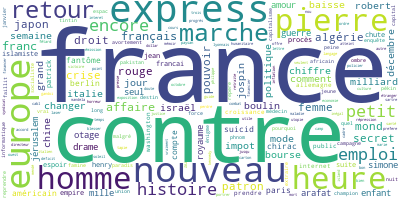

In [10]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list([' '.join(word_list_i) for word_list_i in title_tokens]))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

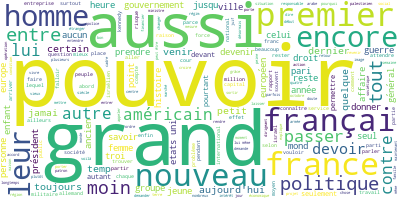

In [11]:
# Same for article bodies
# Join the different processed texts together.
long_string = ','.join(list([' '.join(word_list_i) for word_list_i in text_tokens]))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

__Perform LDA with Gensim__

Fixage arbitraire du nombre de topics, comme on fixerait arbitrairement k dans un k-means.

In [12]:
dic_title = corpora.Dictionary(title_tokens)
dic_text = corpora.Dictionary(text_tokens)
corpus_title = [dic_title.doc2bow(token) for token in title_tokens]
corpus_text = [dic_text.doc2bow(token) for token in text_tokens]

pickle.dump(corpus_title, open('corpus_title.pkl', 'wb'))
dic_title.save('dic_title.gensim')
pickle.dump(corpus_title, open('corpus_text.pkl', 'wb'))
dic_text.save('dic_text.gensim')

In [13]:
print([k for k in dic_title.values()])

['espac', 'tintin', 'boulin', 'robert', 'suicide', 'certitude', 'contre', 'pierre', 'mercredi', 'otage', 'soudain', 'planète', 'rouge', 'secret', 'ammar', 'forcer', 'marche', 'champion', 'discret', 'olympique', 'quinon', 'algérie', 'faillit', 'sanglant', 'israël', 'ébranlé', 'homme', 'objet', 'ponge', 'bess', 'georges', 'pourquoi', 'africain', 'long', 'mémoire', 'malgré', 'antigone', 'benazir', 'bhutto', 'janvier', 'pakistan', 'soupçon', 'triangle', 'campagne', 'ombre', 'darwin', 'tromper', 'dayan', 'symbole', 'impopulaire', 'leader', 'pérè', 'shimon', 'exclusif', 'finit', 'phnom', 'témoignage', 'expliqu', 'simone', 'bureau', 'informatique', 'livré', 'jérusalem', 'nouveau', 'seul', 'chopinet', 'express', 'retrouve', 'touvier', 'tutelle', 'agent', 'faux', 'france', 'star', 'vrai', 'complexe', 'pinochet', 'challenger', 'drame', 'beineix', 'coluche', 'nourricier', 'marchandage', 'terrorisme', 'enquête', 'reprendre', 'espagne', 'goytisolo', 'sarrasin', 'attentat', 'blanco', 'carrero', 'déc

In [14]:
# get the topics! 

NUM_TOPICS = 10

for (corpus, dictionary) in [(corpus_title, dic_title), (corpus_text, dic_text)]:
    print('\nTopics')
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
    ldamodel.save('model5.gensim')
    topics = ldamodel.print_topics(num_words=4)
    for topic in topics:
        print(topic)


Topics
(0, '0.018*"express" + 0.008*"retour" + 0.008*"commando" + 0.008*"dollar"')
(1, '0.009*"franc" + 0.009*"jour" + 0.006*"pouvoir" + 0.006*"homme"')
(2, '0.007*"express" + 0.007*"homme" + 0.007*"affaire" + 0.007*"grand"')
(3, '0.010*"nouveau" + 0.010*"robert" + 0.010*"boulin" + 0.010*"japon"')
(4, '0.014*"heure" + 0.010*"compte" + 0.007*"patron" + 0.007*"médecin"')
(5, '0.021*"france" + 0.008*"petit" + 0.008*"femme" + 0.008*"express"')
(6, '0.010*"italie" + 0.010*"drame" + 0.007*"histoire" + 0.007*"camp"')
(7, '0.018*"europe" + 0.009*"baisse" + 0.009*"français" + 0.006*"crise"')
(8, '0.007*"france" + 0.006*"pierre" + 0.006*"français" + 0.006*"algérie"')
(9, '0.012*"contre" + 0.009*"france" + 0.009*"droit" + 0.006*"retour"')

Topics
(0, '0.003*"pouvoir" + 0.002*"leur" + 0.002*"bousquet" + 0.002*"tout"')
(1, '0.006*"politique" + 0.005*"pouvoir" + 0.005*"france" + 0.004*"français"')
(2, '0.010*"israélien" + 0.010*"israël" + 0.008*"palestinien" + 0.006*"arabe"')
(3, '0.004*"français" 

In [15]:
# to be continued
# https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

__Analysis__

* at first sight, key words associated to the same topic do not always have much in common 
* some of the words used to define topics do not seem like relevant, high level key words
* maybe the corpus is to small or to heterogeneous to obtain relevant topics this way!

--> *Improvement ideas*
- preprocessing: remove figures ('000', '10', '100', '11', '12', '15', '16', '17', '1990', '1997', '20', '30', '31', '50', '500', '60')
- try clustering methods and put a word on the topics
- improve dictionary
- improve this first LDA model (more ideas [here](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/))
- get more data on specific topics


# 2. Clustering 

K-Means clustering and DBSCAN with tf-idf representation



### a. Build a tf-idf matrix to represent the corpus

__Naive approach based on word count__

We rapidly see that the use of lemmas is nessecary to avoid the explosion of our vocabulary. For example, "missives" and "missive" should be considered to be the same. 

In [16]:
#instantiate CountVectorizer() 
cv=CountVectorizer() 
 
# this steps generates word counts for the words in your docs 
word_count_vector=cv.fit_transform(news_df.text)

print(word_count_vector.shape)
# Houston, we have a dimensionality problem

(726, 43869)


In [17]:
# tf-idf with all the words
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

# print idf values 
idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
idf.sort_values(by=['idf_weights'])

,idf_weights
de,1.000000
la,1.022254
le,1.036419
des,1.047896
les,1.052235
...,...
missives,6.895779
missive,6.895779
compensés,6.895779
miradors,6.895779


We have to select the words with highest tf-idf count.

Improvement ideas:
    
* get rid of figures "000", "cinq"
* get rid of non topic words (destructive approach)
* custom build vocabulary for the corpus, based on previous NER extraction 
* use lemmas (root words) instead of full words (ex: français, france go back to the same entity)


__Tf-idf with lemmatized words__

We resuse the preprocessing made in the LDA section. We already obtain a smaller vocabulary, but it remains too big. So next step is to fit the Tf-Idf matrix with some constraints to reduce the number of features.

In [18]:
news_df['pre_title']=[' '.join(word_list_i) for word_list_i in title_tokens] # preprocessed titles
news_df['pre_text']=[' '.join(word_list_i) for word_list_i in text_tokens] # preprocessed article bodies

In [19]:
# Re-compute the word-count for preprocessed texts

word_count_vector=cv.fit_transform(news_df.pre_text)

print(word_count_vector.shape)

# tf-idf with all the words
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

# print idf values 
idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
idf.sort_values(by=['idf_weights'])

(726, 33645)


,idf_weights
pouvoir,1.602474
premier,1.610041
grand,1.617665
nouveau,1.675423
aussi,1.689029
...,...
houleuse,6.895779
houle,6.895779
houillon,6.895779
hooligans,6.895779


__Tf-Idf vectorizer with constraints__

In [20]:
# fit tf-idf on all preprocessed texts with constraints on document frequency and number of tokens
tfidf_vectorizer=TfidfVectorizer(max_df = 700, max_features=500, smooth_idf=True,use_idf=True) #strip_accents=True
X = tfidf_vectorizer.fit_transform(news_df.pre_text) # X is a matrix

In [21]:
# take a look at the result
print(tfidf_vectorizer.get_feature_names())
print(X.shape)

['abord', 'accepter', 'accord', 'action', 'activité', 'administration', 'affaire', 'africain', 'ailleurs', 'algérie', 'algérien', 'allemagne', 'allemand', 'aller', 'américain', 'amériqu', 'ancien', 'annoncer', 'année', 'appel', 'appeler', 'apprendre', 'arabe', 'argent', 'arme', 'armer', 'armée', 'arriver', 'arrêter', 'assez', 'association', 'assurer', 'atteindre', 'attendre', 'aucun', 'aujourd', 'aussi', 'autant', 'autorité', 'autour', 'autre', 'avenir', 'avocat', 'avril', 'beaucoup', 'begin', 'bernard', 'besoin', 'blanc', 'bon', 'cadre', 'campagne', 'capital', 'cause', 'celui', 'centaine', 'central', 'centre', 'certain', 'certains', 'chacun', 'chambre', 'chance', 'changer', 'chaque', 'charger', 'chef', 'chercher', 'chiffre', 'chine', 'chinois', 'chirac', 'choisir', 'choix', 'chose', 'chômage', 'civil', 'clair', 'commencer', 'comment', 'commission', 'commun', 'communauté', 'communiste', 'comprendre', 'compris', 'compte', 'condition', 'conduire', 'connaître', 'conseil', 'continuer', 'co

### b.  K-Means Clustering 

We don't know how many clusters we might have, so we explore a ange of values for hyperparameter k and assess the quality of the clusters using the silhouette score. If our dataset had been labeled we could have used the adjusted rand index instead.

In [22]:
from sklearn.cluster import KMeans
#from sklearn.metrics import adjusted_rand_score(labels_true, labels_pred)
from sklearn.metrics import silhouette_score

# training
k_scores=[]
for k in range(2, 21):
    k_model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=2905,)
    k_labels = k_model.fit_predict(X)
    score = silhouette_score(X, k_labels,metric='cosine', sample_size=None)
    k_scores.append(score)

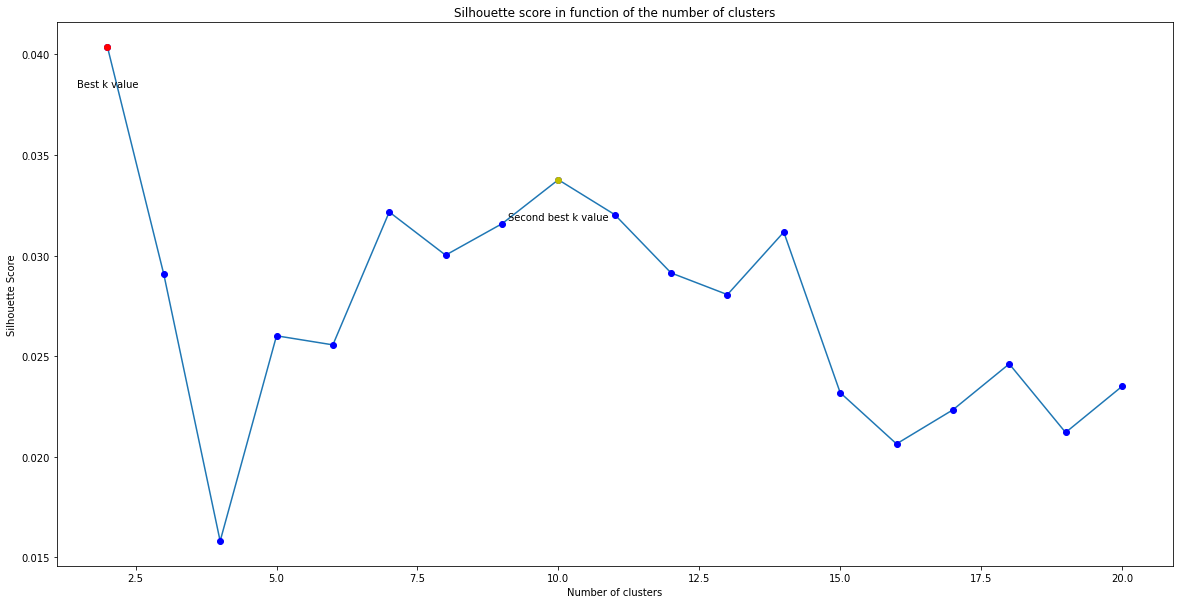

In [23]:
# visualize
plt.figure(figsize=(20,10))
x_val = [k for k in range(2,21)]
y_val = k_scores
plt.plot(x_val,y_val)

plt.plot(x_val,y_val,'ob') 
plt.plot(x_val[np.argmax(y_val)], np.max(y_val), 'or') 
plt.annotate("Best k value",
             (x_val[np.argmax(y_val)], np.max(y_val)),
             textcoords="offset points", 
             xytext=(0,-40), 
             ha='center')

x_val = [k for k in range(3,21)]
y_val = k_scores[1:]
plt.plot(x_val[np.argmax(y_val)], np.max(y_val), 'oy') 
plt.annotate("Second best k value",
             (x_val[np.argmax(y_val)], np.max(y_val)),
             textcoords="offset points", 
             xytext=(0,-40), 
             ha='center')

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score in function of the number of clusters') 
plt.show()

So we will use either k=2 or k=16. Let's see if we can interprete the clusters by assigning them a relevant topic.

In [24]:
news_clusters=news_df.copy()
news_clusters['k_2']=KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1, random_state=2905).fit_predict(X)
news_clusters['k_10']=KMeans(n_clusters=16, init='k-means++', max_iter=100, n_init=1, random_state=2905).fit_predict(X)
news_clusters.head(10)

,Unnamed: 0,year,title,text,url,pre_title,pre_text,k_2,k_10
0,0,1988,Tintin dans l'espace,Trois semaines à bord de la station soviétique...,https://www.lexpress.fr/informations/tintin-da...,tintin espac,trois semaine station soviétique jean-loup chr...,0,10
1,1,1988,Le faux suicide de Robert Boulin,1979 : son corps est découvert en forêt de Ram...,https://www.lexpress.fr/actualite/politique/le...,suicide robert boulin,corps découvrir forêt rambouillet faux piste n...,0,1
2,2,1988,Des pierres contre les certitudes,"Rideaux de fer baissés, silhouettes furtives, ...",https://www.lexpress.fr/actualite/monde/proche...,pierre contre certitude,rideal baisser silhouette furtif jérusalem ara...,0,4
3,3,1988,"Otages: soudain, mercredi soir...",""" Je lui ai dit: ""Ça suffit"", et j'ai raccroch...",https://www.lexpress.fr/informations/otages-so...,otage soudain mercredi,suffit raccrocher souvent échauder souvent tro...,0,10
4,4,1988,Les secrets de la planète rouge,"S'il existe, dans le système solaire, un seul ...",https://www.lexpress.fr/actualite/sciences/les...,secret planète rouge,existe système solaire endroit exobiologister ...,1,12
5,5,1988,La marche forcée d'Abou Ammar,"Prêt à la guerre en 1974, offrant la paix en 1...",https://www.lexpress.fr/informations/la-marche...,marche forcer ammar,guerre offrir arafat cherche auprès alliés isr...,0,4
6,6,1988,"Pierre Quinon, discret champion olympique",Pierre Quinon s'est donné la mort à 49 ans le ...,https://www.lexpress.fr/actualite/sport/pierre...,pierre quinon discret champion olympique,pierre quinon donner hyère portrer consacrer s...,0,12
7,7,1988,Algérie: la faillite sanglante,Au moins 1000 morts. Des milliers de blessés. ...,https://www.lexpress.fr/informations/algerie-l...,algérie faillit sanglant,moins mort millier blessé arrestation masser j...,0,14
8,8,1988,Les deux mois qui ont ébranlé Israël,Israël avait pris l'habitude de mesurer ses gu...,https://www.lexpress.fr/actualite/monde/proche...,ébranlé israël,israël habitude mesurer guerre journée trouble...,0,5
9,9,1988,Ponge: l'homme objets.,"Francis Ponge célébra la Guêpe, un "" petit sip...",https://www.lexpress.fr/informations/ponge-l-h...,ponge homme objet,francis ponge célébra guêpe petit siphon ambul...,1,8


In [25]:
# Look at the repartition between clusters
print(news_clusters.groupby(["k_2"])["year"].count())
print(news_clusters.groupby(["k_10"])["year"].count())
print(news_clusters.groupby(["k_2", "k_10"])["year"].count())

k_2
0    379
1    347
Name: year, dtype: int64
k_10
0      12
1      51
2       9
3       8
4      14
5      28
6      47
7      45
8     151
9      16
10     53
11     61
12     57
13     51
14    101
15     22
Name: year, dtype: int64
k_2  k_10
0    1        49
     4        14
     5        28
     6        42
     7        11
     8        17
     10       32
     11       41
     12       43
     13        2
     14      100
1    0        12
     1         2
     2         9
     3         8
     6         5
     7        34
     8       134
     9        16
     10       21
     11       20
     12       14
     13       49
     14        1
     15       22
Name: year, dtype: int64


In [26]:
# Try to identify topics inside clusters
for i in range(16):
    print("\nCluster ", i)
    print(news_clusters[news_clusters["k_10"]==i].title[:10]) # print 10 titles from each cluster


Cluster  0
84         L impossible reponse concertee a la recession
88                                  QUERELLE DE CHIFFRES
411    Asie du sud encore trop pauvre pour un vrai de...
441                                            Industrie
484                                                  18h
502       3 5 la croissance mondiale 2000 vue par le fmi
520    Italie la production industrielle rechute en s...
530       Lionel jospin parie sur une france tgv en 2000
546                La france championne de la croissance
547    Italie la banque d italie chiffre la reprise e...
Name: title, dtype: object

Cluster  1
1                      Le faux suicide de Robert Boulin
26                      L'Express retrouve Paul Touvier
28                France: fausses stars et vrais agents
33                      Terrorisme: le marchandage raté
34                   Boulin : le juge reprend l'enquête
36    20 décembre 1973 : l'attentat contre Carrero B...
44                      Patricia Hearst: no

On parvient à la liste de thèmes suivants:
    
* Infos nationales France / économie 
* Infos nationales France / économie et entreprises, emploi, compétitivité
* Infos nationales France / Société
* Infos nationales France /  Femmes et débats de société (ex: avortement)
* Infos nationales France / Faits divers


* International / économie internationale
* International / Moyen Orient / politique
* International / politique internationale (anciennes colonies notamment), conflits
* International / Europe / économie
* International / Europe / politique


* Affaires judiciaires et criminelles
* Santé, Biologie, Sciences
* Sport
* Culture


On se rend compte que les thèmes serait mieux décrits par un fonctionnement matriciel, id est __un aspect géographique combiné à un aspect thématique__.

* Géographie: France - Amérique - Europe - Asie - Afrique - Moyen Orient et même peut-être une région transverse "anciennes colonnies françaises"

* Thèmes: Sciences/Santé - Politique - Economie/Entreprises - Société/Faits divers - Affaires judiciaires 

__D'où la nécessité dune double classfication géographique et thématique, pour obtenir le thème final de l'article.__


__Temporality__

Are some topics time-bound ? When did what topic particularly gain momentum ?

Idea: topics like women's right to abort in France or the first French astronaut in space are related to precise events, respectively the corresponding law defended by Simone Weil and Jean-Loup Chrétien's trip to the ISS. Other topics, like French and internaitonal economics, are more likely to be always there, although sometines not at the forefront of the scene.

*Idea: once we have labelled the data, visualize the topics as a fonction of time*

### c. Clustering with entity-based vocabulary

__Tf-idf with entity-based vocabulary__

to do: notebook 01 --> add other entity types (ORG and TIME ?)

*Note on PER entities*

* Some cleaning might be necessary, for example 'ii' is considered as a single entity although it should be 'jean-paul ii' as a whole. 

* Also we are faced with multiple wordings for the same name. For example 'de gaulle' and 'général de gaulle' should be considered to be the same. 

* Most entities are personal names, like 'chirac', but some are categories, like 'président de la république' and might refer to a different person depending on the year the article was published.

* Errors are due to the French "-", for example '-major' should be "état-major", "-aviv" is probably coming from "Tel-aviv"

Nonetheless, the PER list is quite satisfying already.

*Note on LOC entities*

Similar remarks apply 

* cleaning necessary: '»' etc should be deleted
* 'france', 'la france' should be the same, "l'espagne" should be "espagne" etc
* 'état' is a category and should not be mistaken with 'etats-unis'
* errors are trickier to explain, a few verbs are in the list: 'croyez', 'voudrais', 'avais'

In [27]:
PER_df=pd.read_csv('articles_PER.csv')
LOC_df=pd.read_csv('articles_LOC.csv')
print(PER_df.describe())
print(LOC_df.describe())

       Unnamed: 0   PER_count
count  287.000000  287.000000
mean   143.000000    5.487805
std     82.993976    4.539534
min      0.000000    3.000000
25%     71.500000    3.000000
50%    143.000000    4.000000
75%    214.500000    6.000000
max    286.000000   35.000000
       Unnamed: 0   LOC_count
count   439.00000  439.000000
mean    219.00000    9.621868
std     126.87264   17.268576
min       0.00000    3.000000
25%     109.50000    3.000000
50%     219.00000    5.000000
75%     328.50000    8.500000
max     438.00000  158.000000


In [28]:
PER_highest=PER_df[PER_df['PER_count']>5]
print("There are %s PER entities with >5 occurences.\n" %len(PER_highest))
print(list(PER_highest.PER_entity))
PER_highest[:5]


There are 84 PER entities with >5 occurences.

['françois mitterrand', 'jacques chirac', 'ii', 'de gaulle', 'président de la république', 'lionel jospin', 'général de gaulle', 'chirac', 'yasser arafat', 'mitterrand', 'menahem begin', 'bill clinton', 'charles pasqua', 'moshe dayan', 'arafat', 'hier', 'staline', 'alain juppé', 'edouard balladur', '-major', 'washington', 'begin', '-aviv', '-ci', 'itzhak rabin', 'sadate', 'lénine', 'golda meir', 'fini', 'helmut kohl', 'pierre bérégovoy', 'martine aubry', 'kennedy', 'hitler', "valéry giscard d'estaing", 'nasser', 'rabin', 'raymond barre', 'expert', 'shimon peres', 'napoléon', 'eisenhower', 'hasard', 'giscard', 'george bush', 'mao', 'saddam hussein', 'boulin', 'delmas', 'david ben gourion', 'robert badinter', 'georges pompidou', 'anouar el-sadate', 'voulez', 'jean-paul ii', 'christ', 'jimmy carter', 'michel rocard', 'voltaire', 'pierre mendès france', 'pierre mauroy', 'robert', 'regardez', 'marx', 'françoise giroud', 'soudain', 'mendès franc

,Unnamed: 0,PER_entity,PER_count
0,0,françois mitterrand,35
1,1,jacques chirac,31
2,2,ii,29
3,3,de gaulle,26
4,4,président de la république,26


In [29]:
LOC_highest=LOC_df[LOC_df['LOC_count']>6]
print("There are %s LOC entities with >6 occurences.\n" %len(LOC_highest))
print(list(LOC_highest.LOC_entity))
LOC_highest[:5]

There are 154 LOC entities with >6 occurences.

['paris', 'france', 'la france', 'etat', 'etats-unis', 'europe', '-', "l'europe", 'allemagne', 'américains', 'état', 'de france', 'israël', 'londres', 'jérusalem', 'français', 'grande-bretagne', 'moscou', 'terre', 'washington', 'chine', 'afrique', '»', 'la chine', 'amérique', 'new york', 'algérie', 'allemands', 'angleterre', 'occident', 'berlin', 'italie', 'japon', 'beyrouth', 'espagne', 'genève', 'russie', 'suisse', 'pékin', "l'amérique", 'bruxelles', 'soleil', "l'italie", 'f', 'gaza', 'liban', 'cisjordanie', 'syrie', 'la terre', 'jordanie', 'iran', 'sinaï', 'asie', 'mercredi', 'damas', 'cher', 'lyon', 'européens', 'lune', "l'afrique", 'russes', 'pologne', 'egypte', 'algériens', 'israéliens', 'rome', 'c?ur', 'anglais', 'alger', 'inde', 'cuba', 'arabie saoudite', 'matignon', 'marseille', 'irak', 'vienne', "l'empire", 'madrid', 'pacifique', 'hongrie', 'suède', 'bordeaux', "l'algérie", 'tunisie', 'strasbourg', 'atlantique', 'britanniques', 

,Unnamed: 0,LOC_entity,LOC_count
0,0,paris,158
1,1,france,156
2,2,la france,144
3,3,etat,124
4,4,etats-unis,116


Now that we  have looked at the extracted entities, we are going to preprocess them the same way we did for the texts and titles earlier, and then use the keywords we obtain as vocabulary to build a new Tf-Idf matrix. Finally, we re-train k-means models and analyse the results to see if the relevance of individual clusters has improved regarding topic modelling.

Note: one possible issue are the surnames that appear as autonomous entities after splitting full names, e.g. "louis-ferdinand céline" is a French author, "céline dion" is a singer, the family name of the first is the surname of the second. "Prince Harry" has nothing to do with singer "Prince". We see the need for word embeddings coming right toward us!

In [30]:
# preprocessing of individual entities

#v0: use all entities
voc_PER = []
for PER in PER_df['PER_entity']:
    voc_PER+=prepare_text(PER) # PER : one string, preprocessed PER is a list containing 0 to n strings
print(voc_PER)

#v1: use most common entities only 

['françois', 'mitterrand', 'jacques', 'chirac', 'gaulle', 'président', 'républiqu', 'lionel', 'jospin', 'général', 'gaulle', 'chirac', 'yasser', 'arafat', 'mitterrand', 'menahem', 'begin', 'clinton', 'charles', 'pasqua', 'moshe', 'dayan', 'arafat', 'staline', 'alain', 'juppé', 'edouard', 'balladur', '-major', 'washington', 'begin', '-aviv', 'itzhak', 'rabin', 'sadate', 'lénine', 'golda', 'helmut', 'pierre', 'bérégovoy', 'martin', 'aubry', 'kennedy', 'hitler', 'valéry', 'giscard', 'estaing', 'nasser', 'rabin', 'raymond', 'barre', 'expert', 'shimon', 'pere', 'napoléon', 'eisenhower', 'hasard', 'giscard', 'george', 'saddam', 'hussein', 'boulin', 'delmas', 'david', 'gourion', 'robert', 'badinter', 'georges', 'pompidou', 'anouar', 'sadate', 'vouloir', 'jean-paul', 'christ', 'jimmy', 'carter', 'michel', 'rocard', 'voltair', 'pierre', 'mendès', 'france', 'pierre', 'mauroy', 'robert', 'regardez', 'françoise', 'giroud', 'soudain', 'mendè', 'france', 'pompidou', 'louis', 'mikhaïl', 'gorbatchev',

In [31]:
#v0: use all entities
voc_LOC = []
for LOC in LOC_df['LOC_entity']:
    voc_LOC+=prepare_text(LOC) # idem
print(voc_LOC)

['paris', 'france', 'france', 'etats-unis', 'europe', 'europe', 'allemagne', 'américain', 'france', 'israël', 'londre', 'jérusalem', 'français', 'grande-bretagne', 'moscou', 'terre', 'washington', 'chine', 'afriqu', 'chine', 'amériqu', 'algérie', 'allemand', 'angleterre', 'occident', 'berlin', 'itali', 'japon', 'beyrouth', 'espagn', 'genève', 'russie', 'suisse', 'pékin', 'amériqu', 'bruxelle', 'soleil', 'itali', 'liban', 'cisjordanie', 'syrie', 'terre', 'jordanie', 'sinaï', 'mercredi', 'damas', 'européen', 'afriqu', 'russe', 'pologn', 'egypte', 'algérien', 'israélien', 'anglais', 'alger', 'arabie', 'saoudite', 'matignon', 'marseill', 'vienn', 'empire', 'madrid', 'pacifique', 'hongrie', 'suède', 'bordeaux', 'algérie', 'tunisie', 'strasbourg', 'atlantique', 'britannique', 'soudan', 'orsay', 'mexique', 'belgiqu', 'sien', 'maroc', 'chinois', 'japonais', 'italien', 'téhéran', 'angele', 'champagne', 'syrien', 'turqui', 'munich', 'egyptien', 'afriqu', 'liby', 'danemark', 'américain', 'hexagon

In [32]:
# define vocab
my_vocab=list(set(voc_LOC+voc_PER))
print("Entity-based vocabulary of size ", len(my_vocab))

Entity-based vocabulary of size  641


__KMeans__

(726, 289)


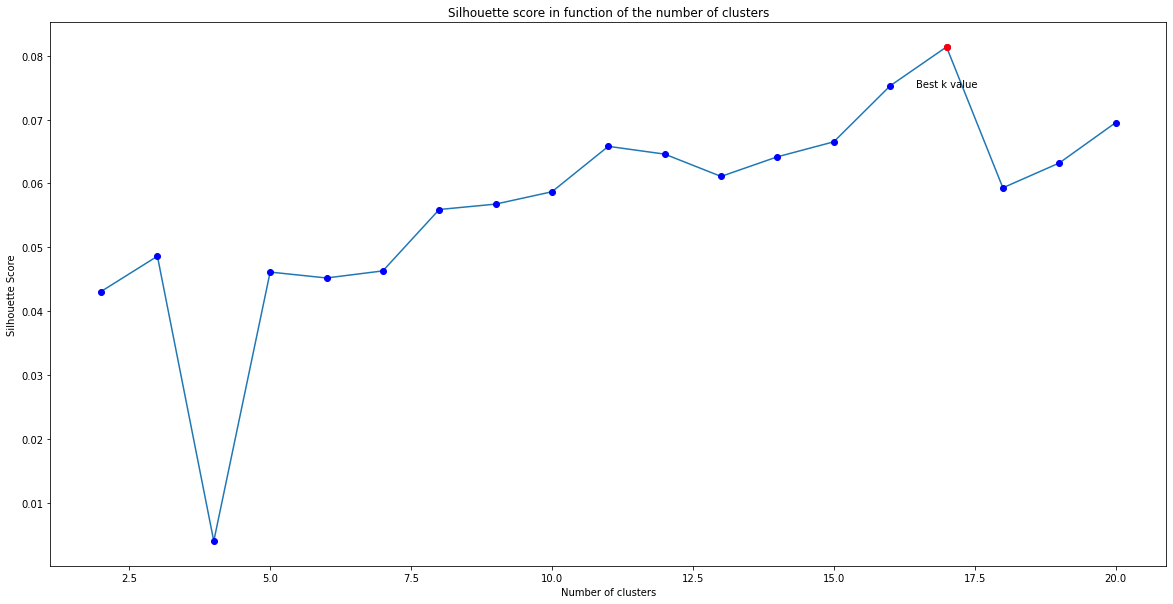

In [33]:
## PER entities only ##

# fit new tf-idf on all preprocessed texts with new vocab and constraints on document frequency and number of tokens
tfidf_vectorizer_vocab=TfidfVectorizer(vocabulary=list(set(voc_PER))) # my_vocab = PER+LOC preprocessed entities
X_vocab = tfidf_vectorizer_vocab.fit_transform(news_df.pre_text) # X is a matrix
print(X_vocab.shape)

# training
k_scores=[]
for k in range(2, 21):
    k_model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=2905,)
    k_labels = k_model.fit_predict(X_vocab)
    score = silhouette_score(X_vocab, k_labels,metric='cosine', sample_size=None)
    k_scores.append(score)
    
# visualize
plt.figure(figsize=(20,10))
x_val = [k for k in range(2,21)]
y_val = k_scores
plt.plot(x_val,y_val)

plt.plot(x_val,y_val,'ob') 
plt.plot(x_val[np.argmax(y_val)], np.max(y_val), 'or') 
plt.annotate("Best k value",
             (x_val[np.argmax(y_val)], np.max(y_val)),
             textcoords="offset points", 
             xytext=(0,-40), 
             ha='center')

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score in function of the number of clusters') 
plt.show()

In [34]:
news_clusters['k_PER_17']=KMeans(n_clusters=17, init='k-means++', max_iter=100, n_init=1, random_state=2905).fit_predict(X_vocab)

# repartition
print(news_clusters.groupby(["k_PER_17"])["year"].count())

# Try to identify topics inside clusters
for i in range(17):
    print("\nCluster ", i)
    print(news_clusters[news_clusters["k_PER_17"]==i].title[:10]) # print 10 titles from each cluster

k_PER_17
0       5
1      13
2      98
3      20
4     341
5      72
6      26
7       4
8       3
9      25
10      6
11     77
12      4
13      5
14      3
15     10
16     14
Name: year, dtype: int64

Cluster  0
88                                  QUERELLE DE CHIFFRES
303    La ponction sur le marche financier pourrait a...
329                          Les nouvelles regles du jeu
396                      Juppe s attaque a la corruption
457                                      Parretti menacé
Name: title, dtype: object

Cluster  1
129                           Les morts de l'espace
133                          Une nouvelle Amérique?
134                              Un grand capitaine
200    Les Nigérians misent désormais sur la famine
288                         "Kennedy dans la crise"
315           Un internationaliste a contre courant
391                             Le dernier dialogue
393                  Les Américains dans le guêpier
394                           La nouvelle fr

(726, 362)


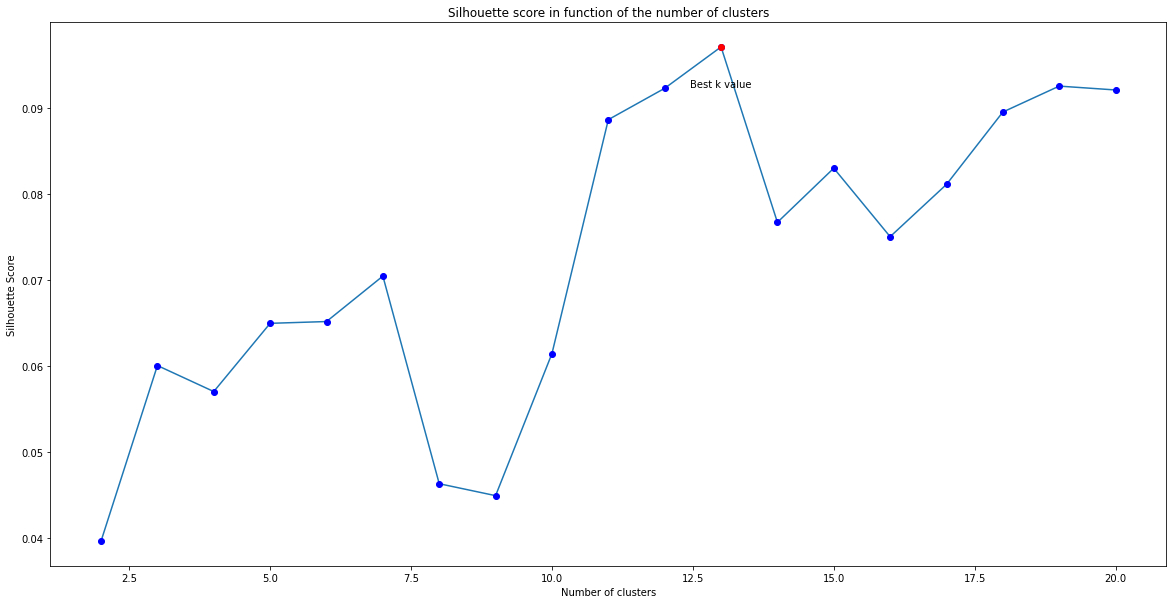

In [35]:
## LOC entities only ##

# fit new tf-idf on all preprocessed texts with new vocab and constraints on document frequency and number of tokens
tfidf_vectorizer_vocab=TfidfVectorizer(vocabulary=list(set(voc_LOC))) # my_vocab = PER+LOC preprocessed entities
X_vocab = tfidf_vectorizer_vocab.fit_transform(news_df.pre_text) # X is a matrix
print(X_vocab.shape)

# training
k_scores=[]
for k in range(2, 21):
    k_model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=2905,)
    k_labels = k_model.fit_predict(X_vocab)
    score = silhouette_score(X_vocab, k_labels,metric='cosine', sample_size=None)
    k_scores.append(score)
    
# visualize
plt.figure(figsize=(20,10))
x_val = [k for k in range(2,21)]
y_val = k_scores
plt.plot(x_val,y_val)

plt.plot(x_val,y_val,'ob') 
plt.plot(x_val[np.argmax(y_val)], np.max(y_val), 'or') 
plt.annotate("Best k value",
             (x_val[np.argmax(y_val)], np.max(y_val)),
             textcoords="offset points", 
             xytext=(0,-40), 
             ha='center')

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score in function of the number of clusters') 
plt.show()

The graph outlook is quite strange but good news is the silhouette score, although remaining low, is higher than the first time.  Let's see if clusters can be directly mapped to topics at this stage.

In [36]:
news_clusters['k_LOC_13']=KMeans(n_clusters=13, init='k-means++', max_iter=100, n_init=1, random_state=2905).fit_predict(X_vocab)

# repartition
print(news_clusters.groupby(["k_LOC_13"])["year"].count())

# Try to identify topics inside clusters
for i in range(13):
    print("\nCluster ", i)
    print(news_clusters[news_clusters["k_LOC_13"]==i].title[:20:2]) # print 10 titles from each cluster

k_LOC_13
0      19
1      53
2      29
3      38
4       9
5      16
6      39
7     331
8      15
9     110
10     41
11      9
12     17
Name: year, dtype: int64

Cluster  0
68                            L'envers du paradis en RFA
148                                  Méphisto, le retour
162                         DRESDE OU LA MÉMOIRE BLESSÉE
308                     Les Tziganes, parias de 1'Europe
327                            Sur les routes de l'exode
435                      L'Allemagne réunie par les eaux
497    Allemagne accord de principe sur la retraite a...
501                      Theo waigel conseillera alcatel
508         Deutsche telekom sanctionne la deutsche bank
598                            Des négligences coûteuses
Name: title, dtype: object

Cluster  1
32                               Coluche père nourricier
97                                               Reperes
122                                                Utile
140                             Les joyaux s

(726, 641)


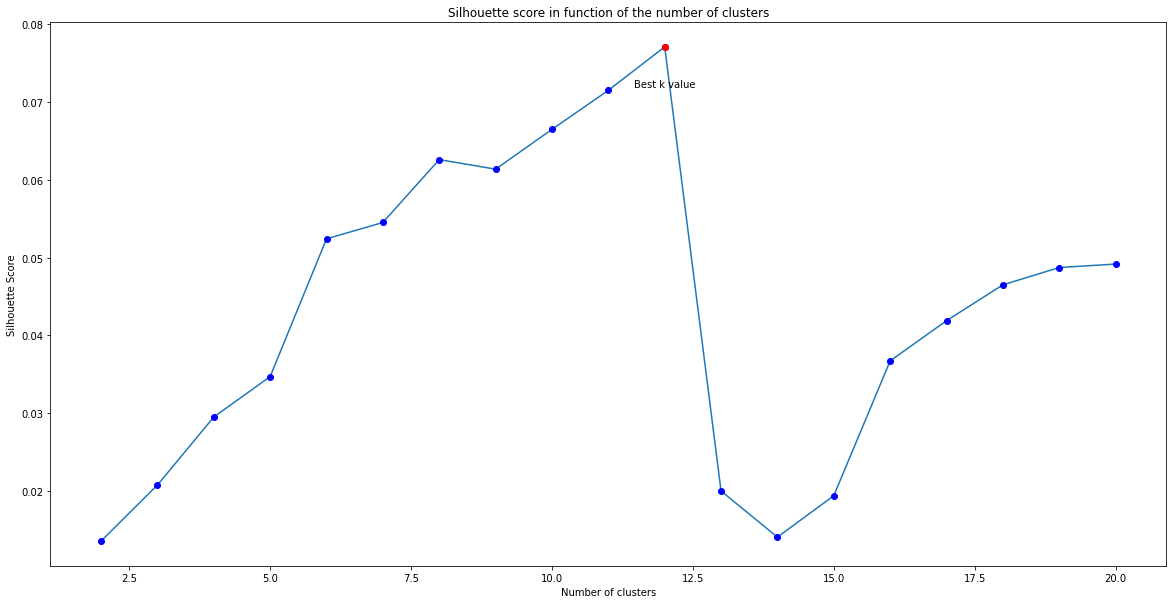

In [37]:
## PER and LOC together ##

# fit new tf-idf on all preprocessed texts with new vocab and constraints on document frequency and number of tokens
tfidf_vectorizer_vocab=TfidfVectorizer(vocabulary=my_vocab) # my_vocab = PER+LOC preprocessed entities
X_vocab = tfidf_vectorizer_vocab.fit_transform(news_df.pre_text) # X is a matrix
print(X_vocab.shape)

# training
k_scores=[]
for k in range(2, 21):
    k_model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=2905,)
    k_labels = k_model.fit_predict(X_vocab)
    score = silhouette_score(X_vocab, k_labels,metric='cosine', sample_size=None)
    k_scores.append(score)
    
# visualize
plt.figure(figsize=(20,10))
x_val = [k for k in range(2,21)]
y_val = k_scores
plt.plot(x_val,y_val)

plt.plot(x_val,y_val,'ob') 
plt.plot(x_val[np.argmax(y_val)], np.max(y_val), 'or') 
plt.annotate("Best k value",
             (x_val[np.argmax(y_val)], np.max(y_val)),
             textcoords="offset points", 
             xytext=(0,-40), 
             ha='center')

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score in function of the number of clusters') 
plt.show()

In [38]:
news_clusters['k_PERLOC_12']=KMeans(n_clusters=12, init='k-means++', max_iter=100, n_init=1, random_state=2905).fit_predict(X_vocab)

# repartition
print(news_clusters.groupby(["k_PERLOC_12"])["year"].count())

# Try to identify topics inside clusters
for i in range(12):
    print("\nCluster ", i)
    print(news_clusters[news_clusters["k_PERLOC_12"]==i].title[:20:2]) # print 10 titles from each cluster

k_PERLOC_12
0      25
1     318
2      35
3      20
4      44
5      20
6      43
7      44
8       8
9      57
10     97
11     15
Name: year, dtype: int64

Cluster  0
54          Mars 1989: la Pologne s'ouvre au capitalisme
88                                  QUERELLE DE CHIFFRES
148                                  Méphisto, le retour
162                         DRESDE OU LA MÉMOIRE BLESSÉE
247                  Berlin a deux doigts de la faillite
308                     Les Tziganes, parias de 1'Europe
328                          Les trois crises allemandes
458                   Westlake: des masques et une plume
462    Du Vel d'Hiv' aux camps, l'histoire de millier...
498                                 Monument aux remords
Name: title, dtype: object

Cluster  1
1                    Le faux suicide de Robert Boulin
4                     Les secrets de la planète rouge
10                    Pourquoi est mort Georges Besse
13                             L'aide, malgré tout...
15    

__Cluster interpretation__

    k_6
    0     81
    1    455
    2     57
    3     69
    4     20
    5     44
    Name: year, dtype: int64

    Cluster  0
    0                             Tintin dans l'espace
    68                      L'envers du paradis en RFA
    80                          LES LIAISONS HEUREUSES
    88                            QUERELLE DE CHIFFRES
    98                     Quelle politique étrangère?
    113                             UNE BOURSE À GÉRER
    153    Jean Gandois: contre la baisse des salaires
    162                   DRESDE OU LA MÉMOIRE BLESSÉE
    178                                L'Europe diluée
    187                   Un nabab au pays des bananes
    Name: title, dtype: object

    Cluster  1
    1                      Le faux suicide de Robert Boulin
    4                       Les secrets de la planète rouge
    9                                Ponge: l'homme objets.
    11                     La longue marche du Che africain
    14    (1e janvier 1988) Benazir Bhutto: l'Antigone d...
    16                              L'ombre sur la campagne
    19                                                 Diva
    22                        1975 : Simone Veil s'explique
    25                                      «Mlle Chopinet»
    27                                 La Nasa sous tutelle
    Name: title, dtype: object

    Cluster  2
    28           France: fausses stars et vrais agents
    39          1973 : les hors-la-loi de l'avortement
    70     Yves Saint-Laurent, le nouvel enfant triste
    77                        PAYSANS, MAIS PAS PLOUCS
    86                      Contre la haine, les juges
    102                             DRÔLE D'ATMOSPHERE
    116                          Courrier des lecteurs
    121                                  MICHEL HERMON
    174    "Que mes lèvres ne sont-elles des cerises!"
    183        L'AÉROPOSTALE - MARCEL BOUILLOUX-LAFONT
    Name: title, dtype: object

    Cluster  3
    32                              Coluche père nourricier
    94     1981 1993 les socialistes et le marche politique
    108                                    Reperes economie
    122                                               Utile
    139                    Taux d interet le debat interdit
    146                               RENSEIGNEMENTS UTILES
    159                         "Sud-Ouest": la trêve amère
    226              Pourquoi le satelli te menace le cable
    235                          La culture flambe a noumea
    247                 Berlin a deux doigts de la faillite
    Name: title, dtype: object

    Cluster  4
    7              Algérie: la faillite sanglante
    56              Algérie: Les jokers de Chadli
    186                  "Paris a fait son choix"
    204                           Un cri d'alarme
    225        Ferhat abbas une utopie algerienne
    307                       La stratégie du FIS
    322    "Notre responsabilité n'est pas mince"
    397               La confession d'un policier
    471          Restez chez vous, l'islam veille
    593          La France peut gagner en Algerie
    Name: title, dtype: object

    Cluster  5
    2         Des pierres contre les certitudes
    8      Les deux mois qui ont ébranlé Israël
    20      Shimon Pérès, le leader impopulaire
    40           Guerre de Kippour. Extraits...
    42                  Yasser Arafat intronisé
    85             Hamas occupe les Territoires
    104      Histoire secrète d'une négociation
    192                      Comptes et légende
    212            Ben Gourion gagne aux points
    273              Gaza: le mois le plus long
    Name: title, dtype: object

* Cluster 0: hard to explain
* Cluster 1: hard to explain
* Cluster 2: French society topics --> not so clear though
* Cluster 3: Economics in France and Europe 
* Cluster 4: Algérie --> cluster has better quality than previously
* Cluster 5: Moyen-Orient --> already obtained with the first tf-idf

So clustering using LOC entities seems to give relevant clusters / have more weight in the decision process here whereas clustering using PER entities doesn't seem to have a strong influence on building clusters corresponding to interpretable topics. 



In [40]:
## PER & LOC ## 

print("Top terms per cluster:")
order_centroids = k_model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer_vocab.get_feature_names()
for i in range(12):
    print ("Cluster %d:" % i,)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind],)

Top terms per cluster:
Cluster 0:
 bérégovoy
 pierre
 rabai
 fédéral
 carlo
 juppé
 balladur
 matignon
 bruxelle
 alain
Cluster 1:
 grand
 américain
 celui
 dernier
 vouloir
 michel
 français
 france
 pierre
 claude
Cluster 2:
 paris
 parisien
 français
 grand
 général
 jacques
 président
 ville
 pierre
 express
Cluster 3:
 algérien
 algérie
 alger
 français
 chadli
 france
 dernier
 président
 général
 djedid
Cluster 4:
 rabai
 express
 européen
 philippe
 charles
 france
 vouloir
 américain
 celui
 français
Cluster 5:
 jospin
 lionel
 français
 chirac
 jacques
 france
 hollande
 françois
 européen
 matignon
Cluster 6:
 européen
 europe
 france
 américain
 français
 atlantique
 dernier
 grand
 allemand
 bruxelle
Cluster 7:
 france
 dernier
 europe
 général
 français
 président
 blondel
 pierre
 autopsie
 dominique
Cluster 8:
 mendè
 mendès
 france
 pierre
 express
 gaulle
 indochine
 mollet
 mitterrand
 français
Cluster 9:
 franc
 france
 grand
 français
 américain
 dernier
 général
 

__Summary__

* For the final vocabulary, keep entities as keywords but not only
* 2 classification: Geography + Topics 